In [35]:
def check_float(textin):
    try:
        float(textin)
        return True

    except ValueError:
        return False

def check_force(folder):
    import os
    import numpy as np
    files = os.listdir(folder)
    cleaned = [int(x) for x in files if check_float(x)]
    if os.path.exists(folder+"/postProcessing/forces/{}".format(np.max(cleaned))):
        return False
    else:
        return True
    
def retrieve_lift(folder,debug=False):
    import os
    import shutil
    import numpy as np
    
    files = os.listdir(folder)
    cleaned = [x for x in files if check_float(x)]
    files = sorted(cleaned)
    needs_forces = check_force(folder)
    if debug:
        print(folder,needs_forces)
    if needs_forces:
        force_command = "rhoSimpleFoam -postProcess -case {} -func forces".format(folder)
        os.system(force_command)
    else:
        pass
    
    forces = np.zeros(3)
    moments = np.zeros(3)
    time = np.array([])
    
    for file in files:    
        with open("{}/postProcessing/forces/{}/forces.dat".format(folder,file)) as f:
            full = f.readlines()
            line = full[3]
            starts = []
            ends = []
            for i in range(len(line)):
                if line[i] == '(' and line[i+1] != '(':
                    starts.append(i+1)
                elif line[i] == ')' and line[i-1] != ')':
                    ends.append(i)
            pressure_forces = np.array([float(x) for x in line[starts[0]:ends[0]].split()])
            viscous_forces = np.array([float(x) for x in line[starts[1]:ends[1]].split()])

            pressure_moments = np.array([float(x) for x in line[starts[2]:ends[2]].split()])
            viscous_moments = np.array([float(x) for x in line[starts[3]:ends[3]].split()])
            forces = np.vstack([forces, pressure_forces + viscous_forces])
            moments = np.vstack([moments, pressure_moments + viscous_moments])
            time = np.append(time,float(file))
    return forces, moments, time    

def max_velocity(folder, debug=False):
    import os
    import shutil
    import numpy as np
    files = os.listdir(folder)
    cleaned = [float(x) for x in files if check_float(x)]
    filename = np.max(cleaned)
    if int(filename) == filename:
        filename = '{}/{}/U'.format(folder,int(filename))
    else:
        filename = '{}/{}/U'.format(folder,filename)
    with open(filename) as f:
        Utext = f.readlines()
    numlines = int(Utext[19])
    start = 21
    end = start+numlines-1
    Umax = 0
    for i in range(start,end):
        line = Utext[i][1:-2]
        vals = [float(x) for x in line.split()]
        Umag = np.sqrt(vals[0]**2 + vals[1]**2)
        if Umag > Umax:
            Umax = Umag
    return Umax

def max_velocity_ind(folder, index):
    import os
    import numpy as np
    files = os.listdir(folder)
    cleaned = [float(x) for x in files if check_float(x)]
    filename = np.max(cleaned)
    if int(filename) == filename:
        filename = '{}/{}/U'.format(folder,int(filename))
    else:
        filename = '{}/{}/U'.format(folder,filename)
    with open(filename) as f:
        Utext = f.readlines()
    line = Utext[index][1:-2]
    vals = [float(x) for x in line.split()]
    Umag = np.sqrt(vals[0]**2 + vals[1]**2)
    return Umag
    
        

def VTK_files(folder,debug=False):
    import os
    vtk_exists = os.path.exists(folder + '/VTK')
    if vtk_exists:
        if debug:
            print('VTK Exists for case: {}'.format(folder))
        pass
    else:
        os.system('foamToVTK -case {} -latestTime'.format(folder))
    for file in os.listdir(folder+'/VTK/'):
        if file[-3:] == 'vtk':
            target = file
        else:
            pass
    return target
    

def find_momentum_thickness(mesh,chord_length,position,Uinf):
    import numpy as np
    c = chord_length    
    p = position
    mesh.set_active_scalars('U')
    x = mesh.sample_over_line([-c+(c*p),0.00,0.078],[-c+(c*p),3.0,0.078])
    Udata = x.point_data['U']
    Umag = np.sqrt(Udata[:,0]**2+Udata[:,1]**2)
    dtheta = (Umag/Uinf)*(1-(Umag/Uinf))
    points = x.points
    y = points[:,1]
    bl = np.trapz(dtheta,x=y)
    return(bl)   

def find_displacement_thickness(mesh,chord_length,position,Uinf):    
    import numpy as np
    c = chord_length    
    p = position
    mesh.set_active_scalars('U')
    x = mesh.sample_over_line([-c+(c*p),0.00,0.078],[-c+(c*p),3.0,0.078])
    Udata = x.point_data['U']
    Umag = np.sqrt(Udata[:,0]**2+Udata[:,1]**2)
    ddelta = (1-(Umag/Uinf))
    points = x.points
    y = points[:,1]
    bl = np.trapz(ddelta,x=y)
    return(bl)   

def find_profile(mesh,position):
    import numpy as np
    p = position
    mesh.set_active_scalars('U')
    x = mesh.sample_over_line([position, -4.8, 0.78],[position,4.8,0.78])
    Udata = x.point_data['U']
    Pdata = x.point_data('P')
    return Udata,Pdata
    

def read_chord_length(folder,line_number = 28):
    with open(folder + '/system/blockMeshDict') as f:
        lines = f.readlines()
        chord_def_line = lines[line_number]
        ind = []
        for j in range(len(chord_def_line)):
            if chord_def_line[j] == '(':
                ind.append(j+1)
            elif chord_def_line[j] == ')':
                ind.append(j)
        numbers = chord_def_line[ind[0]:ind[1]].split(' ')
        cl = -float(numbers[0])
    return cl

def U_from_Re(re,chord):
    mu = 1.82e-5
    rho = 1.17
    U = re * mu / (rho * chord)
    return U

def coanda_plot(cpu,cpl):
    R = 0.12 *  0.0254
    t = 0.012* 0.0254
    h = 0.009 * 0.0254
    x = np.linspace(0,np.pi/2,25)[::-1]
    
    cyl_up = np.zeros([25,2])
    for i in range(25):
        cyl_up[i,0] = R*np.cos(x[i])
        cyl_up[i,1] = R*np.sin(x[i])
    pts_up = np.array([cpu[-1,:],[-R,R+t+h],[-R,R+h],[-R,R]])
    pts_up = np.vstack([pts_up,cyl_up])
    pts_lo = np.array([1,-1]) * pts_up
    return pts_up,pts_lo

def curves_for_plot(cpu,cpl):
    import numpy as np
    co_up, co_lo = coanda_plot(cpu,cpl)
    bez_up = bezier_curve(cpu,201)
    bez_lo = bezier_curve(cpl,201)

    upper = np.vstack([bez_up,co_up])
    lower = np.vstack([bez_lo,co_lo])
    return upper, lower

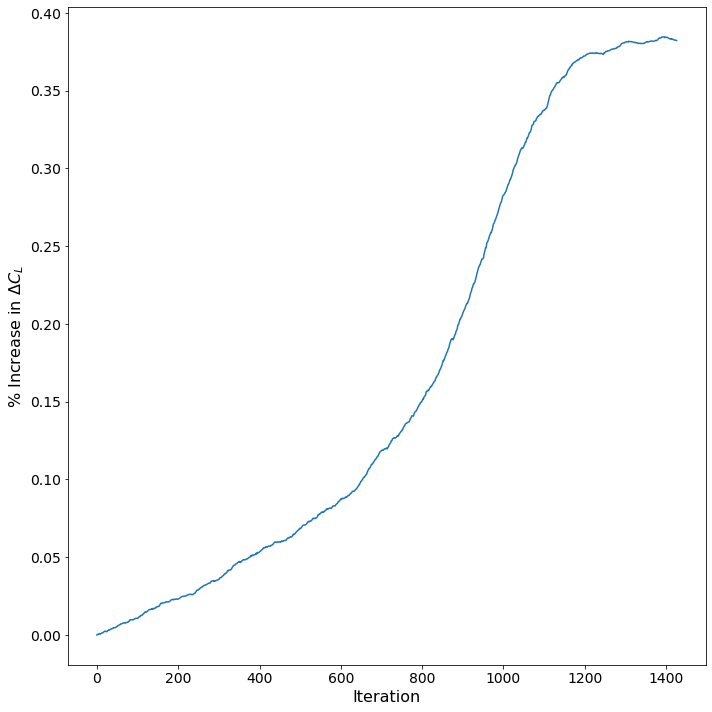

In [34]:
import numpy as np
from matplotlib import pyplot as plt
from bezier_foil import *

output_folder = './output/'
pts_folder = '/home/james/Documents/research/cfd/airfoils/optimization/opt_fd5/'

lift = np.loadtxt(output_folder + 'lift.txt')
lift_base = np.loadtxt(output_folder + 'lift_base.txt')
lift = lift[:-2]
N = len(lift)
net_lift = lift - lift_base[:N]

plt.figure(figsize=[10,10])
plt.plot((net_lift - net_lift[0])/net_lift[0])
plt.tick_params(axis='both',labelsize=14)
plt.xlabel('Iteration',fontsize=16)
plt.ylabel(r'% Increase in $\Delta C_L$',fontsize=16)
plt.tight_layout()
plt.savefig('/home/james/Documents/research/thesis/lift_increase_opt_iter.png')


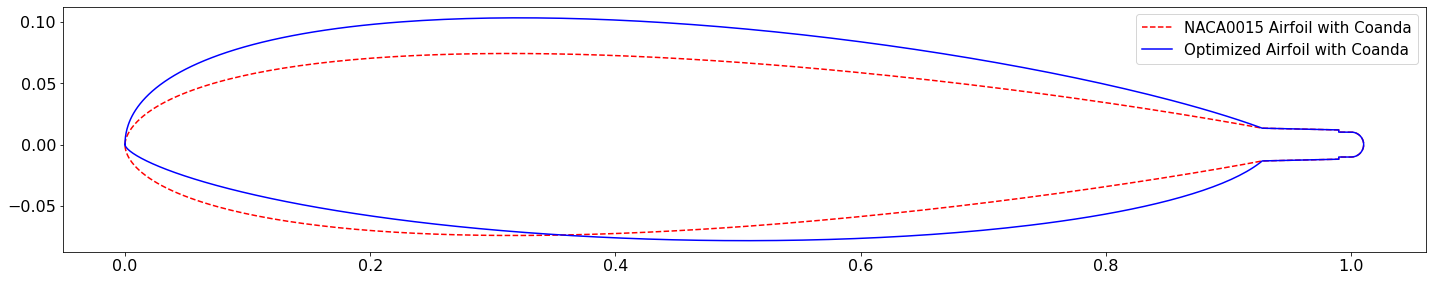

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from processing import *
from bezier_foil import *


pointsdir = '/home/james/Documents/research/cfd/airfoils/optimization/opt_fd5/'



    

plt.figure(figsize=[20,4])

cpu = np.loadtxt(pointsdir+'0_cpu.txt')
cpl = np.loadtxt(pointsdir+'0_cpl.txt')

upper, lower = curves_for_plot(cpu,cpl)
upper = upper / 0.3 + np.array([1,0])
lower = lower / 0.3 + np.array([1,0])
surf = np.vstack([upper,lower[::-1,:]])
plt.plot(surf[:,0],surf[:,1],'r--')

cpu = np.loadtxt(pointsdir+'927_cpu.txt')
cpl = np.loadtxt(pointsdir+'927_cpl.txt')
upper, lower = curves_for_plot(cpu,cpl)
upper = upper / 0.3 + np.array([1,0])
lower = lower / 0.3 + np.array([1,0])
surf = np.vstack([upper,lower[::-1,:]])
plt.plot(surf[:,0],surf[:,1],'b-')

plt.legend(['NACA0015 Airfoil with Coanda','Optimized Airfoil with Coanda'],fontsize=15)
plt.tick_params(axis='both',labelsize=16)


plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig('/home/james/Documents/research/thesis/airfoil_comp_with_coanda.png')


In [ ]:

legend = []
Re = np.array([])
plt.figure()
for i in range(len(flowspeedd)):
    Re = np.append(Re,1.17*float(flowspeedd[i])*0.3/1.82e-5)
    k = int(break_index[i])
    plt.plot(cmud[1:k,i], clsd[1:k,i]/cmud[1:k,i])
    plt.ylim([0,40])
    legend.append('Re = {}'.format(np.around(Re[i],-3)))
plt.legend(legend)

plt.figure(figsize=[10,10])
for i in range(len(flowspeedd)):
    k = int(break_index[i])
    plt.plot(theta[1:k,i] - theta[0,i],clsd[1:k,i])
    legend.append('Re = {}'.format(np.around(Re[i],-3)))
plt.xlabel(r'Change in Momentum Thickness $\Delta \Theta$')
plt.ylabel(r'$\Delta C_L$')
plt.title('Lift Coefficient vs. Momentum Thickness')
plt.legend(legend)
plt.savefig('/home/james/Documents/research/figures/coanda_boundary_layers/momentum_thickness_vs_CL.jpg')

plt.figure(figsize=[10,10])
for i in range(len(flowspeedd)):
    k = int(break_index[i])
    plt.plot(blsd[1:k,i] - blsd[0,i],clsd[1:k,i])
    legend.append('Re = {}'.format(np.around(Re[i],-3)))
plt.ylabel(r'$\Delta C_L$')
plt.xlabel(r'Change in Displacement Thickness $\Delta \delta_1$')
plt.title('Lift Coefficient vs. Displacement Thickness')
plt.legend(legend)
plt.savefig('/home/james/Documents/research/figures/coanda_boundary_layers/displacement_thickness_vs_CL.jpg')

print(cmud[0,:])
print(blsd[0,:])

plt.figure()
plt.plot(Re,blsd[0,:])

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

target_cmu = np.array([0.005, .01, 0.015, 0.02, 0.025])

M = np.shape(cmud)[1]
N = np.shape(cmud)[0]
L = len(target_cmu)

target_ind = np.zeros([M,L])
target_bls = np.zeros([M,L])
target_cls = np.zeros([M,L])
actual_cmu = np.zeros([M,L])

for k in range(L):
    for i in range(M):
        vec = cmud[:,i] - target_cmu[k]
        target_ind[i,k] = int(np.argmin(np.abs(vec)))
        target_bls[i,k] = blsd[int(target_ind[i,k]),i]
        target_cls[i,k] = clsd[int(target_ind[i,k]),i]
        actual_cmu[i,k] = cmud[int(target_ind[i,k]),i]
        
    plt.figure()
    plt.plot(Re,target_cls[:,k]/target_bls[:,k])



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

parent = '/home/james/Documents/research/completed_cases/coanda_airfoils/steady/NACA0015/multidir/'
flowspeed = ['10','15','20','25','30','35']
mdots = np.linspace(-0.006,0.006,25)
lifts = np.zeros([len(mdots),len(flowspeed)])
liftaoa = np.zeros([len(mdots),len(flowspeed)])
drags = np.zeros([len(mdots),len(flowspeed)])
moments = np.zeros([len(mdots),len(flowspeed)])
cmus = np.zeros([len(mdots),len(flowspeed)])

c=0.3
for j in range(len(flowspeed)):
    Q = 0.5 * 1.17 * int(flowspeed[j])**2 * .18
    for i in range(len(mdots)):
        file_ext = str(np.around(mdots[i],4)).replace('-','n')

        case = '/{}mps/{}kgps'.format(flowspeed[j],file_ext)
        if file_ext[0] == 'n':
            ind = 13580
        else:
            ind = 13641
        Umax = max_velocity_ind(parent+case,ind)
        force, moment, time = retrieve_lift(parent+case)
        cmus[i,j] = mdots[i] * Umax / Q
        if cmus[i,j] == 0:
            lifts[i,j] = force[-1,1]/(Q)
        else:
            lifts[i,j] = force[-1,1]/(Q)
        drags[i,j] = force[-1,0]/Q
        moments[i,j] = moment[-1,2]/(Q*c)
legend = []
for i in range(len(flowspeed)):
    U = int(flowspeed[i])
    Re = 1.17*U*c/1.82e-5
    legend.append('Re = {}'.format(str(np.around(Re,-3))))
plt.figure(figsize=[10,10])
for i in range(len(flowspeed)):
    if int(flowspeed[i]) < 20:
        plt.plot(bls[4:-4,i],lifts[4:-4,i])
    else:
        plt.plot(bls[:,i],lifts[:,i])
plt.plot(aoabl,aoacls)
plt.ylabel(r'$C_L$')
plt.xlabel(r'Momentum Thickness $\Theta$')


plt.savefig('/home/james/Documents/research/completed_cases/Cl_vs_theta_full.png')
plt.figure()
plt.plot(bls,drags)
plt.figure()
plt.plot(cmus,bls)

plt.figure()
plt.plot(bls,moments)

In [ ]:
import os
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook
N_startup = 50
folders = os.listdir(directory)

numfold = list([])
goodind = []
for i in range(len(folders)):
    current = folders[i]
    if check_float(current[:-2]):
        numfold.append(float(current[:-2]))
        goodind.append(i)

    else:
        pass
print(goodind)
folders= [folders[k] for k in goodind]
numfold = np.array(numfold)
sorted_nums = np.sort(numfold)
sortind = np.argsort(numfold)
folders = [folders[i] for i in sortind]
timedelay = np.array([])
amp = np.array([])
for i in range(len(folders)):    
#     plt.figure()
    forces, moments, time = data_dict[folders[i]]
    freq = sorted_nums[i]
    k = np.round(freq * np.pi * 0.3 / 20,3)
    Re = np.around(0.3 * 1.225 * 20 / 1.82e-5,decimals=-3)
    Cmu = np.round(0.006 * 190 / (.3 * .5 * 1.225 * 20**2 * .61),2)
    title = "Actuation Case:  $Re = {}$,  $k = {}$,  $C_\mu = {}$".format(int(Re),k,Cmu)
    system_input = np.sin(freq * 2 * np.pi * time)
    CL = forces / (0.5 * 1. * 20**2 * 0.61 * 0.3)
    CM = moments / (0.5 * 1. * 20**2 * 0.61 * 0.3 ** 2)
    amp = np.append(amp,np.max(CL))
    corr = signal.correlate(CL[:-1,1],system_input)
    nsamples = np.size(time)
    dt = np.linspace(-time[-1],time[-1],2*nsamples-1)
    timedelay = np.append(timedelay,dt[np.argmax(corr)])
    plt.figure()
    plt.plot(time,CM[:-1,2],time,CL[:-1,1])
    plt.xlabel('Time (s)')
    plt.ylabel('$C_L$')
    plt.title(title)
    
phaseshift = timedelay * 360 * sorted_nums
    
plt.figure()
plt.plot(sorted_nums,phaseshift,'*')
plt.xscale('log')
plt.title('Response Phase vs. Input Frequency')
plt.ylabel('Phase (Deg)')
plt.xlabel('Frequency (Hz)')


plt.figure()
plt.loglog(sorted_nums,amp,'*')
plt.title('Response Amplitude vs. Input Frequency')
plt.ylabel('$C_L$ Amplitude')
plt.xlabel('Frequency (Hz)')

In [ ]:
## For Impulse Cases

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import control

#directory = '/media/james//imp_005dur_100start'
directory = '/home/james/Documents/research/completed_cases/coanda_airfoils/'
filename = 'imp_0015dur_200start'
data = retrieve_lift(directory+filename)

In [ ]:
# Data Plotting And Input Processing
c = 0.3
U = 20
rho = 1.17
b = .61
QS = .5 * rho * U**2 * c * b
tau = c / U
start = 100
dur = 5
input_signal = np.zeros([1001,1])
input_signal[start:start+dur] = 1
time = data[2] / tau
lift = data[0][:-1,1]
CL = lift / QS
print(np.shape(lift))
drag = data[0][:-1,0]
CD = drag / QS
start = 401
plt.figure(figsize = [6,6])
plt.plot(time[start:],CL[start:])
plt.plot(time[start:],CD[start:])


plt.title("Impulse Response\n1.5ms Duration, 200ms Start Time",fontsize='x-large')
plt.ylabel('Force (N)',fontsize='large')
plt.xlabel('Convective Times',fontsize='large')
plt.legend(['Lift','Drag'],fontsize='x-large')

#plt.savefig('impulse_005dur_100start.png')

In [ ]:
import numpy as np

x = np.ones([5,2])
print(x[:5,:])

In [ ]:
import control
import random
from scipy import signal
from scipy import linalg as la
from matplotlib import pyplot as plt

def era(YY,m,n,nin,nout,r):
    from scipy import linalg as la
    import numpy as np
    Dr = np.zeros([nout,nin])
    Y  = np.zeros([nout,nin,len(YY[0,0,:])-1])
    for i in range(nout):
        for j in range(nin):
            Dr[i,j] = YY[i,j,0]
            Y[i,j,:] = YY[i,j,1:]
            
    assert(len(Y[:,0,0])==nout)
    assert(len(Y[0,:,0])==nin)
    assert(len(Y[0,0,:])>=m+n)
    
    H = np.zeros([m,n])
    H2 = np.zeros([m,n])
    
    
    for i in range(m):
        for j in range(n):
            for Q in range(nout):
                for P in range(nin):
                    H[nout*i-nout+Q+1,nin*j-nin+P+1] = Y[Q,P,i+j]
                    H2[nout*i-nout+Q+1,nin*j-nin+P+1] = Y[Q,P,i+j+1]
    [U,S,V] = la.svd(H,full_matrices=False)
    V = V.T
    Sm = np.eye(len(S))*S
    Sigma = Sm[0:r,0:r]
    Ur = U[:,:r]
    Vr = V[:,:r]
    Ar = np.dot(la.inv(Sigma)**.5,np.dot(Ur.T,np.dot(H2,np.dot(Vr,la.inv((Sigma))**.5))))
    Br = np.dot((Sigma**.5),np.dot(Ur.T,H[:,0:nin]))
    Cr = (np.dot(H[:nout,:],np.dot(Vr, Sigma**(0.5))))
    HSVs = S[0:r]
    return Ar,Br,Cr,Dr,HSVs
    

start_index = 401
y = CL[start_index:]
nStates = 5
t = np.linspace(0,1,len(y))
dt = t[1]-t[0]
nt = len(t)

plt.figure()
plt.plot(t,y)

NumberTimeShifts = 5*nStates
NumberSnaps = nt-NumberTimeShifts-1
r = nStates
YY = np.zeros([1,1,len(y)])
YY[0,0,:] = y
[Ar,Br,Cr,Dr,HSVs] = era(YY,NumberTimeShifts,NumberSnaps,nInputs, nOutputs, r)

sys2 = control.ss(Ar,Br,Cr*dt,Dr*dt,dt)
y2,t2 = control.matlab.impulse(sys2,t)

plt.figure()
plt.plot(t2,y2,'r-',t,y,'b--')


plt.figure(figsize = [5,5])
xc = np.linspace(-np.pi,np.pi,101)
[vals2,vecs2] = la.eig(sys2.A)
plt.plot(np.real(vals2),np.imag(vals2),'b*')
plt.plot(np.cos(xc),np.sin(xc))
plt.xlim([-1,1])
plt.ylim([-1,1])

In [ ]:
import numpy as np

